# Module 1: Basics of Machine Learning
## Part 1: Regression

In this notebook, we illustrate the application of PyTorch to regress the aqueous solubility of different molecules using a neural network model.

### 1. Install and load python libraries

In [ ]:
!pip install torch numpy matplotlib scikit-learn pandas rdkit-pypi

In [10]:
# Required Libraries
import torch  # PyTorch main package
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt  # Plotting library
from sklearn.datasets import make_regression  # To generate synthetic regression data
from sklearn.model_selection import train_test_split  # To split data into train/test sets
from sklearn.preprocessing import StandardScaler  # To standardize data
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import pandas as pd # Pandas for handling input data
from rdkit import Chem # Work with molecules
from rdkit.Chem import Draw # Draw molecules

### 2. Load and Prepare Solubility Data

In [15]:
!wget https://raw.githubusercontent.com/mcsorkun/AqSolDB/refs/heads/master/results/data_curated.csv
data = pd.read_csv('data_curated.csv')

--2025-05-09 01:17:52--  https://raw.githubusercontent.com/mcsorkun/AqSolDB/refs/heads/master/results/data_curated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750252 (3.6M) [text/plain]
Saving to: ‘data_curated.csv.1’

data_curated.csv.1  100%[===================>]   3.58M  --.-KB/s    in 0.07s   

2025-05-09 01:17:53 (47.9 MB/s) - ‘data_curated.csv.1’ saved [3750252/3750252]



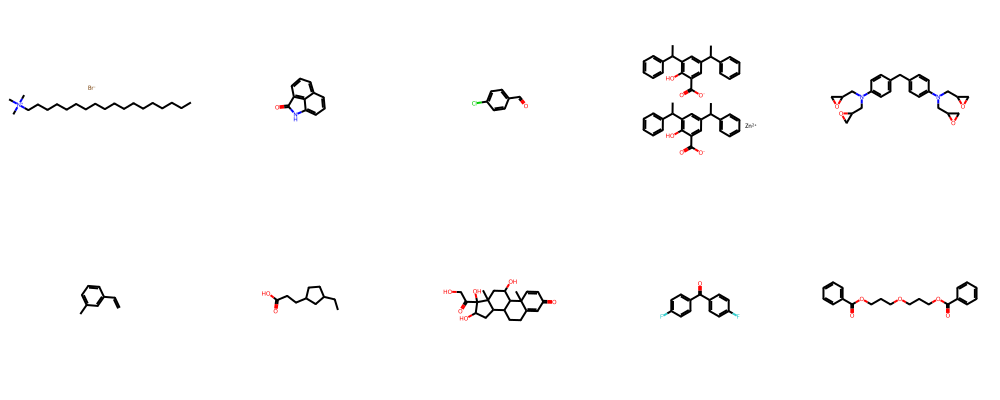

In [16]:
# Visualize molecules in the data set
smiles_list = data['SMILES'][0:10]
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=5)

In [17]:
# Choose some features and define X
descriptor_names=['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount','NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds','NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']
X=data[descriptor_names].to_numpy()
# Define y as the solubility (logS)
y=data['Solubility'].to_numpy()

/tmp/ipykernel_2942194/894204753.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


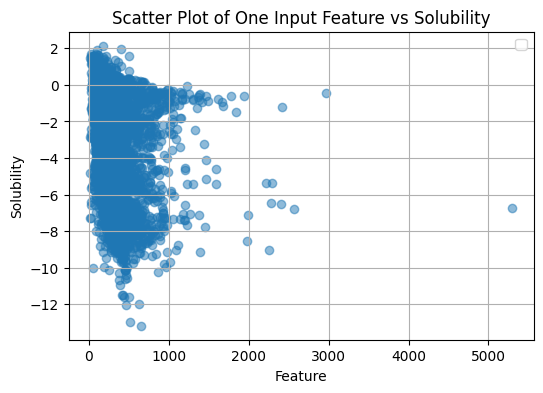

In [18]:
# Prepare the data set
y = y.reshape(-1, 1)  # Make y a column vector

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features and target
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
# Create a DataLoader with minibatches
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Show
plt.figure(figsize=(6, 4))
plt.scatter(X[:, descriptor_names.index("MolWt")], y, alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Solubility')
plt.title('Scatter Plot of One Input Feature vs Solubility')
plt.grid(True)
plt.legend()
plt.show()

### 3. Define Machine Learning Setup (Neural Network Model, Loss, Optimizer)

In [19]:
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()

        # Define layers explicitly
        self.layer1 = nn.Linear(input_size, 64)
        self.activation1 = nn.ReLU()

        self.layer2 = nn.Linear(64, 32)
        self.activation2 = nn.ReLU()

        self.output_layer = nn.Linear(32, 1)  # No activation here (regression)

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        x = self.output_layer(x)
        return x

In [33]:
# Instantiate Model
input_size = X_train.shape[1]
model = RegressionNN(input_size)

# Define Loss Function (MSE for regression)
criterion = nn.MSELoss()

# Define Optimizer (Adam with learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 4. Train the Model

In [34]:
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    # --------- Training ---------
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)  # sum loss over the batch
    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # --------- Testing ---------
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test)
        test_loss = criterion(test_preds, y_test)
        test_losses.append(test_loss.item())

    # Print every 1 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch [1/50], Train Loss: 0.3363, Test Loss: 0.4196
Epoch [2/50], Train Loss: 0.2409, Test Loss: 0.3452
Epoch [3/50], Train Loss: 0.2745, Test Loss: 0.3153
Epoch [4/50], Train Loss: 0.4243, Test Loss: 0.3029
Epoch [5/50], Train Loss: 0.2321, Test Loss: 0.2825
Epoch [6/50], Train Loss: 0.4549, Test Loss: 0.2780
Epoch [7/50], Train Loss: 0.2252, Test Loss: 0.2680
Epoch [8/50], Train Loss: 0.3145, Test Loss: 0.2715
Epoch [9/50], Train Loss: 0.1427, Test Loss: 0.2639
Epoch [10/50], Train Loss: 0.2407, Test Loss: 0.2600
Epoch [11/50], Train Loss: 0.2422, Test Loss: 0.2555
Epoch [12/50], Train Loss: 0.1697, Test Loss: 0.2526
Epoch [13/50], Train Loss: 0.1819, Test Loss: 0.2527
Epoch [14/50], Train Loss: 0.1697, Test Loss: 0.2479
Epoch [15/50], Train Loss: 0.2374, Test Loss: 0.2435
Epoch [16/50], Train Loss: 0.2720, Test Loss: 0.2440
Epoch [17/50], Train Loss: 0.2645, Test Loss: 0.2382
Epoch [18/50], Train Loss: 0.1762, Test Loss: 0.2396
Epoch [19/50], Train Loss: 0.1929, Test Loss: 0.2361
Ep

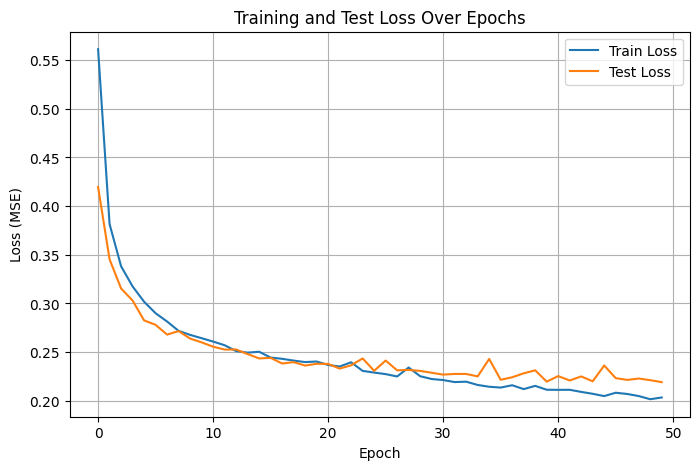

In [35]:
# Plot Training and Test Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Test Loss Over Epochs')
plt.grid(True)
plt.show()

# 5. Make and Visualize Predictions

In [36]:
model.eval()
with torch.no_grad():
    y_pred_all = model(X_test).numpy()
    y_actual_all = y_test.numpy()

y_pred_all = scaler_y.inverse_transform(y_pred_all)
y_actual_all = scaler_y.inverse_transform(y_actual_all)

In [37]:
# Compute MAE and RMSE
mae = mean_absolute_error(y_actual_all, y_pred_all)
rmse = root_mean_squared_error(y_actual_all, y_pred_all)
print("Mean Absolute Error (MAE) is: ", mae)
print("Root Mean Squared Error (MAE) is: ", rmse)

Mean Absolute Error (MAE) is:  0.8040813207626343
Root Mean Squared Error (MAE) is:  1.1128567457199097


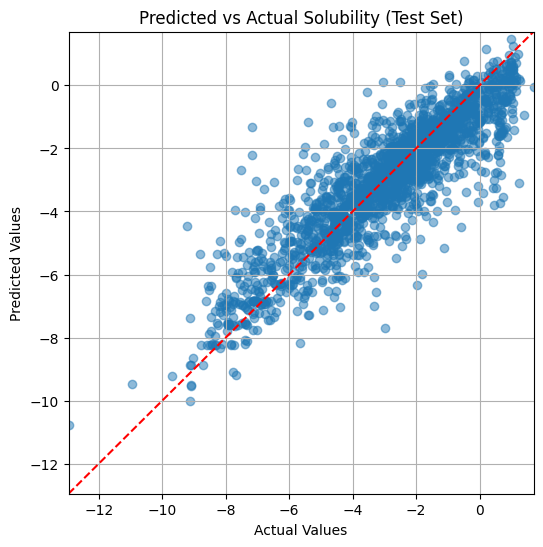

In [38]:
# Plotting
plt.figure(figsize=(6,6))
plt.scatter(y_actual_all, y_pred_all, alpha=0.5)
plt.plot([y_actual_all.min(), y_actual_all.max()],
         [y_actual_all.min(), y_actual_all.max()], 'r--')
plt.xlim([y_actual_all.min(), y_actual_all.max()])
plt.ylim([y_actual_all.min(), y_actual_all.max()])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Solubility (Test Set)")
plt.grid(True)
plt.show()

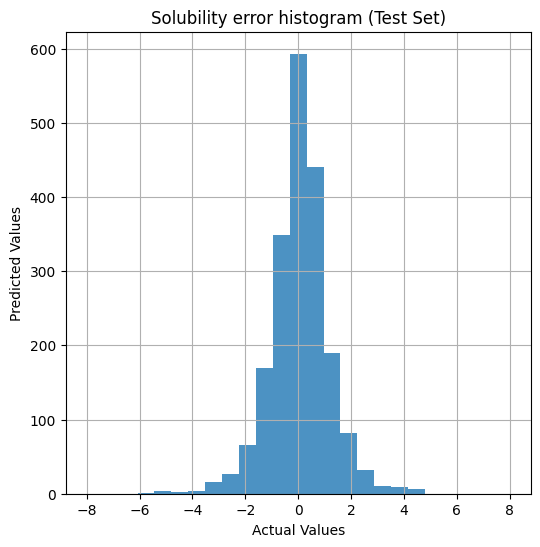

In [39]:
# Plotting
plt.figure(figsize=(6,6))
plt.hist(y_actual_all- y_pred_all, alpha=0.8, range=(-8,8),bins=25)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Solubility error histogram (Test Set)")
plt.grid(True)
plt.show()

In [40]:
# Use gradients to estimate feature importance
model.eval()
X_test.requires_grad = True
output = model(X_test)
output.mean().backward()

# Feature importance = average of absolute gradients across samples
feature_importance = X_test.grad.abs().mean(dim=0)

print("Feature Importance:", feature_importance)

Feature Importance: tensor([0.0004, 0.0011, 0.0006, 0.0010, 0.0003, 0.0003, 0.0004, 0.0002, 0.0013,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0006, 0.0002, 0.0003])


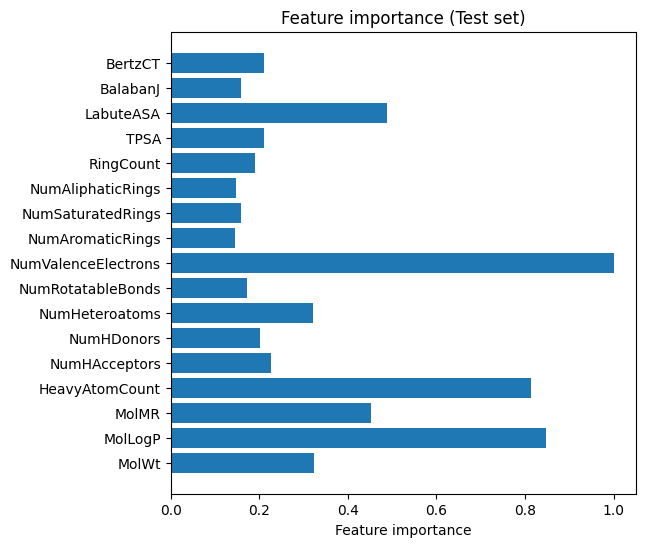

In [41]:
plt.figure(figsize=(6,6))
plt.barh(descriptor_names,feature_importance/torch.max(feature_importance))
plt.title("Feature importance (Test set)")
plt.xlabel("Feature importance")
#plt.xticks(rotation=90)
plt.show()